In [1534]:
from datetime import date
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
import scipy.stats as ss
warnings.filterwarnings('ignore')
%matplotlib inline
import statsmodels.api as sm


# Given Informatiom

In [654]:
s0=100
Rf=0.05
vol=0.31
mu=0.1
size=7
dt=1/256

## Simulating the Stock Price

In [663]:
def simulation_days(days=7):
    d=pd.DataFrame()
    stock=s0
    for i in range(days+1):
        stock=stock * (np.exp( ((mu-((vol)**2/2)) * dt) + (vol*np.sqrt(dt)*np.random.normal())))  #black Scholes Equation for stock price
        d=d.append(pd.Series(stock),ignore_index=True)
    d.iloc[0]=s0
    return round(d,2)
    

In [664]:
def simulation(number_of_simulation=1000):
    frame=pd.DataFrame()
    for i in range(number_of_simulation):
        simulation=simulation_days().T
        frame=frame.append(simulation)
    frame=frame.T
    return frame

In [665]:
simulation=simulation()

In [666]:
simulation

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
1,103.94,101.70,100.02,99.67,95.95,100.15,107.64,99.20,99.76,102.03,...,96.90,96.81,97.47,99.13,98.74,89.58,98.53,98.89,102.99,103.32
2,103.71,100.44,100.55,103.00,94.57,102.09,105.42,98.60,101.37,96.80,...,97.50,95.67,97.74,99.83,95.57,87.77,96.21,98.29,101.34,103.80
3,105.67,103.74,104.03,105.08,94.16,102.88,106.15,94.86,100.64,96.72,...,94.55,99.12,97.48,98.34,97.08,89.22,96.32,97.60,100.89,104.77
4,108.87,103.35,102.24,102.61,91.65,102.71,105.16,93.87,99.74,97.94,...,93.18,96.42,101.74,95.33,97.48,91.23,95.34,96.83,100.65,106.52
5,106.12,104.44,103.10,104.19,91.68,104.88,105.24,93.23,99.57,99.79,...,92.37,95.63,101.51,93.15,97.55,92.07,93.34,94.45,100.15,106.41
6,107.09,106.45,102.75,109.57,89.83,105.35,107.74,93.50,98.87,99.24,...,89.90,95.14,100.01,92.03,96.85,91.52,92.02,92.08,100.71,104.77
7,107.62,107.16,101.99,110.34,88.69,104.16,105.10,93.46,96.88,101.22,...,89.05,93.80,102.48,89.98,95.66,90.85,90.26,94.86,100.42,106.53


In [667]:
seventh_day=(simulation.iloc[-1])

### 7th day Stat

In [668]:
pd.DataFrame(data=[seventh_day.max(),seventh_day.min(),seventh_day.mean(),seventh_day.median(),seventh_day.std(),seventh_day.skew(),seventh_day.kurt()],index=['Max','Min','Mean','Median','Std','Skewness','Excess of Kurtosis'],columns=['Stat'])

,Stat
Max,120.560000
Min,83.690000
Mean,100.168220
Median,100.035000
Std,5.533737
Skewness,0.147144
Excess of Kurtosis,0.181560


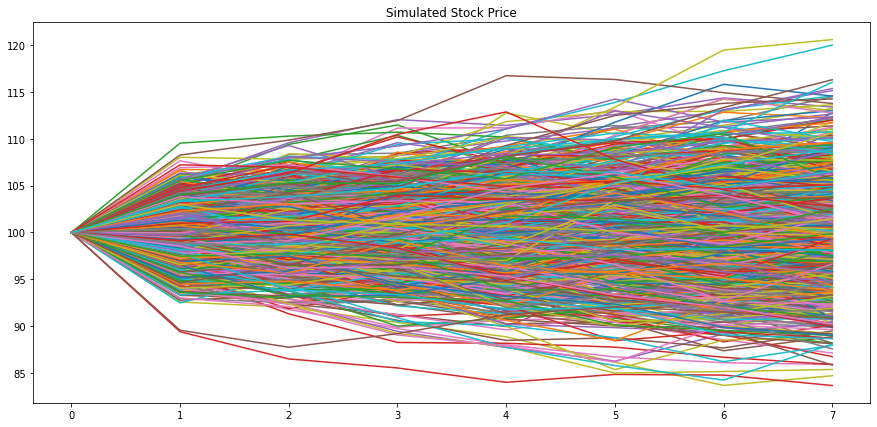

In [669]:
simulation.plot(figsize=(15,7),legend=False,title='Simulated Stock Price')

### Distribution

In [670]:
last_day=pd.DataFrame(simulation.iloc[-1])

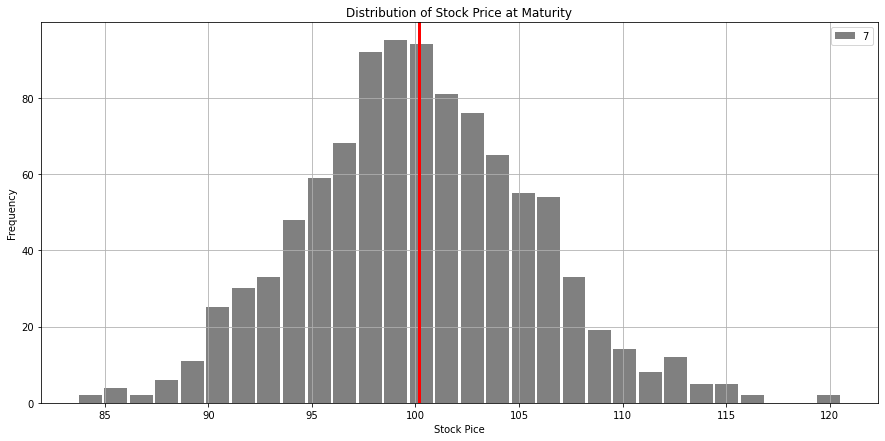

In [671]:
last_day.plot.hist(grid=True, bins=30, rwidth=0.9, color='Grey',figsize=(15,7),title='Distribution of Stock Price at Maturity')
plt.xlabel("Stock Pice")
plt.axvline(x=last_day.mean().values[0],color='Red', lw=3)

In [1570]:
### Probability of the Stock less than 1% Quantile, 87, 88, 89

print("Probability of Stock less than 87 is " + str((ss.norm.cdf(87,loc=last_day.mean().values[0],scale=last_day.std().values[0]))*100) + str('%'))

print("Probability of Stock less than 88 is " + str((ss.norm.cdf(88,loc=last_day.mean().values[0],scale=last_day.std().values[0]))*100) + str('%'))

print("Probability of Stock less than 89 is " + str((ss.norm.cdf(89,loc=last_day.mean().values[0],scale=last_day.std().values[0]))*100) + str('%'))

print("Probability of Stock less than 1% Quantile is " + str((ss.norm.cdf(np.quantile(last_day,0.01),loc=last_day.mean().values[0],scale=last_day.std().values[0]))*100) + str('%'))

k3=np.quantile(last_day,0.01)

print("1% Quantile of the Distribution is:" +str( k3))


Probability of Stock less than 87 is 0.8665123683031039%
Probability of Stock less than 88 is 1.3941960783160392%
Probability of Stock less than 89 is 2.1784910149076424%
Probability of Stock less than 1% Quantile is 1.4588765196091873%
1% Quantile of the Distribution is:88.0987


# PART: 2

## Delta Hedging

## Pricing a barrier option

In [1480]:
def price_bar(strike=89,st=100,Rf=Rf,sigma=vol,T=(7/256),t=(0/256)):
    d3 = (np.log(st/strike)  + (Rf-((sigma**2)/2))*(T-t))/(sigma * np.sqrt(T-t))
    price =  np.exp(-Rf*(T-t))*ss.norm.cdf(-d3)
    return price
        


## Payoff of Barrier Option

In [1481]:
def barrier_profit(strike=89,end_price=70,premium=0.4,buy=True):
    "According the pay off given, the indicator function is 1 when the End Price is less than Strike"
    " Else the buyer loses the premium and gets knocked out"
    if buy:
        
        if end_price < strike:
            profit=1-premium          # Xt=1
        else:
            profit=-premium
            
        " With the seller of the option Exact opposite pay off will be there, if the option goes ITM then he will loose"
        " Else will keep the premium"
    else:
        
        if end_price < strike:
            profit=-1+premium
        else:
            profit=premium
    
    return profit

In [1482]:
barrier_profit(buy=False)  # Selling Barrier Option, if the end price is less than strike, seller makes the loss

-0.6

## Delta of the Barrier Option

In [1483]:
def deltab(strike=89,st=100,Rf=Rf,sigma=vol,T=(7/256),t=(0/256)):
    
    d3 = (np.log(st/strike)  + (Rf-((sigma**2)/2))*(T-t))/(sigma * np.sqrt(T-t))
    
    N  = ss.norm.pdf(d3)
    
    delta = -np.exp(-Rf*(T-t))*(N/(sigma*st*np.sqrt(T-t)))
    
    return delta

## Price of the Given Digital Option

In [1484]:
bar_price=price_bar(strike=89,st=100,Rf=Rf,sigma=vol,T=(7/256),t=(0/256))

In [1485]:
bar_price

0.011456391936188736

In [1486]:
# Selling 100 barrier option with price of 0.0111

In [1487]:
Total_premium=bar_price*100

## Total Premium Collected

In [1488]:
Total_premium

1.1456391936188737

## Without Hedging

In [1539]:
df_b=pd.DataFrame()
for ab in range(len(last_day)):
    profitb=barrier_profit(strike=89,end_price=last_day.iloc[ab].values[0],premium=bar_price,buy=False)*100
    df_b=df_b.append(pd.Series(profitb),ignore_index=True)
df_b.columns=['Profit']

In [1540]:
df_b.index=last_day.iloc[:,0]

In [1541]:
df_b=df_b.sort_index()

## Payoff from option without Hedging

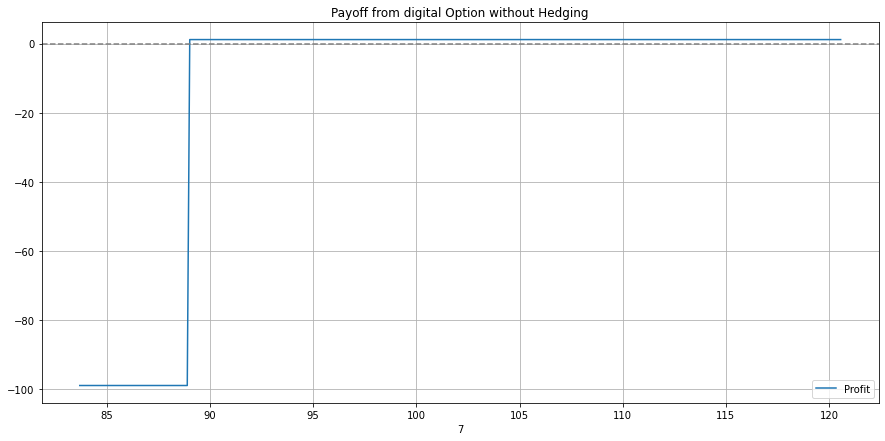

In [1542]:
df_b.plot(figsize=(15,7),title='Payoff from digital Option without Hedging',grid=True)
plt.axhline(y=0,color='Grey',ls ='--')


## Key Stats 

In [1493]:
df_b.max(),df_b.min(),df_b.std(),-np.percentile(df_b,0.01)  # Max, # Min, #Standard deviation, # Var 99%

(Profit    1.145639
 dtype: float64,
 Profit   -98.854361
 dtype: float64,
 Profit    13.659304
 dtype: float64,
 98.85436080638112)

## Distribution

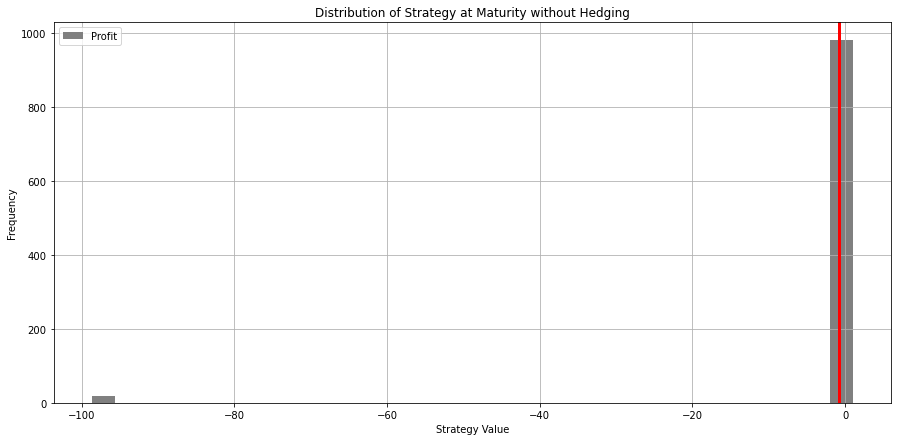

In [1494]:
df_b.plot.hist(grid=True, bins=30, rwidth=0.9, color='Grey',figsize=(15,7),title='Distribution of Strategy at Maturity without Hedging')
plt.xlabel("Strategy Value")
plt.axvline(x=df_b.mean().values[0],color='Red', lw=3)

## Hedging at Start

In [1495]:
delta=deltab()

## Delta at the begining

In [1496]:
delta # as delta is negative we sell shares to make delta neutrality (we sell the option)

-0.0058516929080962175

In [1497]:
number_of_share=(-delta*s0)

## Number of Shares to be sold

In [1498]:
number_of_share  # sell shares at spot

0.5851692908096218

In [1499]:
def stock_payoff(s0=100,st=89,buy=True):
    if buy:
        profit=st-s0
            
    else:  #shorting the stock
            profit=s0-st
            
            
    return profit
            

In [1500]:
stock_payoff(buy=False)

11

## Now, at '0' our position is selling 100 barrier option and selling delta shares, selling price is 100

In [1501]:
df_h=pd.DataFrame()
for aj in range(len(last_day)):
    profith=(barrier_profit(strike=89,end_price=last_day.iloc[aj].values[0],premium=bar_price,buy=False)*100 +
            stock_payoff(s0=100,st=last_day.iloc[aj].values[0],buy=False)*number_of_share)
    df_h=df_h.append(pd.Series(profith),ignore_index=True)
df_h.columns=['Profit']

In [1502]:
df_h.index=last_day.iloc[:,0]
df_h=df_h.sort_index()

## Payoff from the Strategy with Hedging at start

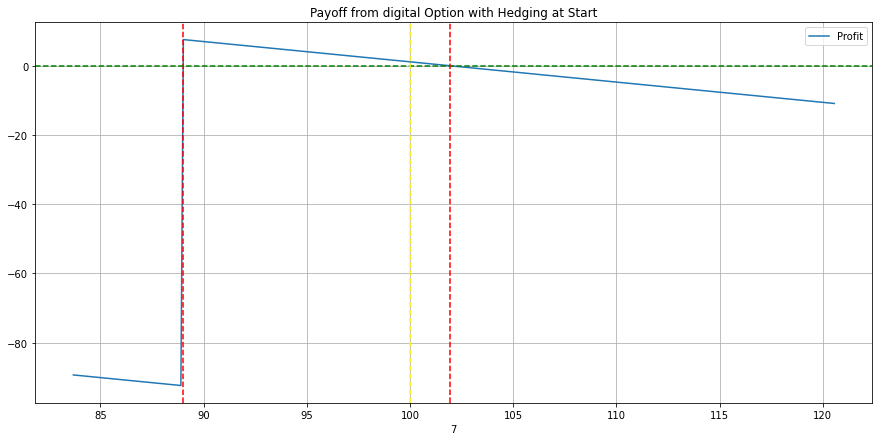

In [1503]:
df_h.plot(figsize=(15,7),title='Payoff from digital Option with Hedging at Start',grid=True)
plt.axvline(x=89,color='Red',ls ='--')
plt.axhline(y=0,color='green',ls ='--')
plt.axvline(x=100,color='yellow',ls ='--')
plt.axvline(x=df_h[df_h>=0].dropna().idxmin()[0],color='Red',ls ='--')

## Distribution of the strategy with Hedging at Start

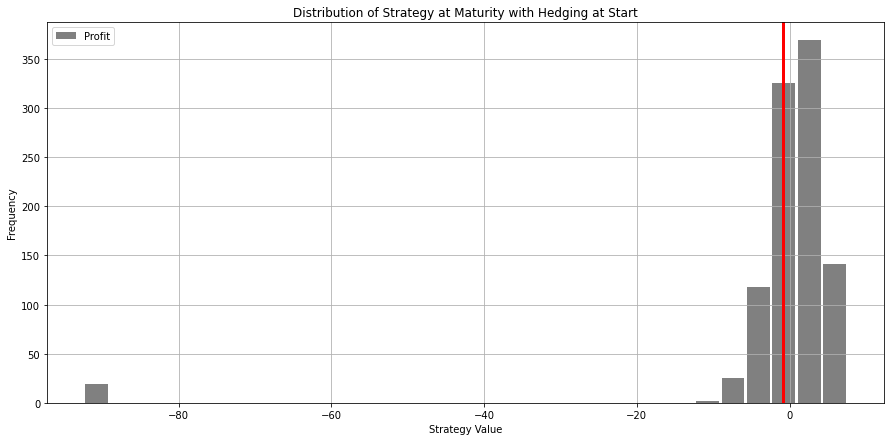

In [1504]:
df_h.plot.hist(grid=True, bins=30, rwidth=0.9, color='Grey',figsize=(15,7),title='Distribution of Strategy at Maturity with Hedging at Start')
plt.xlabel("Strategy Value")
plt.axvline(x=df_h.mean().values[0],color='Red', lw=3)

## Key Stats

In [1505]:
df_h.max(),df_h.min(),df_h.std(),-np.percentile(df_h,0.01)  # Max, # Min, #Standard deviation, # Var

(Profit    7.570798
 dtype: float64,
 Profit   -92.358982
 dtype: float64,
 Profit    12.972141
 dtype: float64,
 92.35138208481459)

In [1528]:
gh=pd.concat([df_b,df_h],axis=1)
gh.columns=['Without Hedge','Static Hedge']

## Comparison

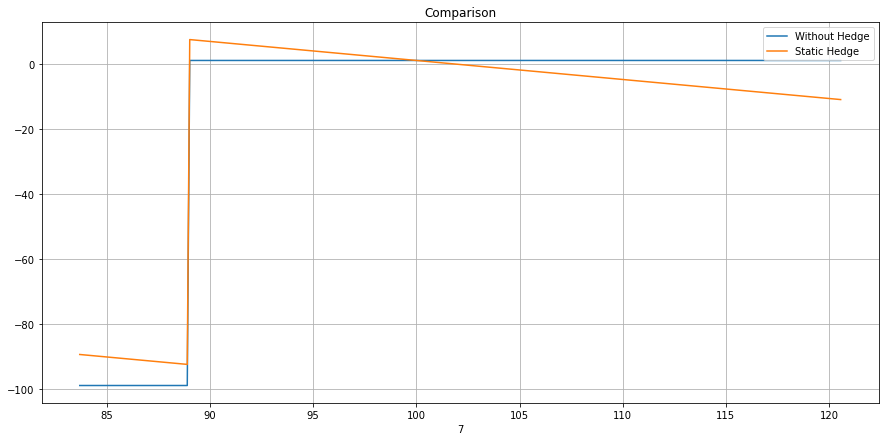

In [1530]:
gh.plot(figsize=(15,7),title='Comparison',grid=True)


## Hedging at 3rd day

In [1508]:
simulation

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
1,103.94,101.70,100.02,99.67,95.95,100.15,107.64,99.20,99.76,102.03,...,96.90,96.81,97.47,99.13,98.74,89.58,98.53,98.89,102.99,103.32
2,103.71,100.44,100.55,103.00,94.57,102.09,105.42,98.60,101.37,96.80,...,97.50,95.67,97.74,99.83,95.57,87.77,96.21,98.29,101.34,103.80
3,105.67,103.74,104.03,105.08,94.16,102.88,106.15,94.86,100.64,96.72,...,94.55,99.12,97.48,98.34,97.08,89.22,96.32,97.60,100.89,104.77
4,108.87,103.35,102.24,102.61,91.65,102.71,105.16,93.87,99.74,97.94,...,93.18,96.42,101.74,95.33,97.48,91.23,95.34,96.83,100.65,106.52
5,106.12,104.44,103.10,104.19,91.68,104.88,105.24,93.23,99.57,99.79,...,92.37,95.63,101.51,93.15,97.55,92.07,93.34,94.45,100.15,106.41
6,107.09,106.45,102.75,109.57,89.83,105.35,107.74,93.50,98.87,99.24,...,89.90,95.14,100.01,92.03,96.85,91.52,92.02,92.08,100.71,104.77
7,107.62,107.16,101.99,110.34,88.69,104.16,105.10,93.46,96.88,101.22,...,89.05,93.80,102.48,89.98,95.66,90.85,90.26,94.86,100.42,106.53


In [1509]:
def Delta_frame(q):
    frame=pd.DataFrame()
    for k in range(len(q)):
        de=deltab(strike=89,st=q.iloc[k],Rf=Rf,sigma=0.31,T=(len(q)-1)/256,t=k/256)
        frame=frame.append(pd.Series(de),ignore_index=True)
    return frame

In [1510]:
dvf=pd.DataFrame()
for l in range(len(simulation.columns)):
    q=simulation.iloc[:,l]
    dde=Delta_frame(q).T
    dvf=dvf.append(dde)
dvf=dvf.T  
    

### Calculating the Delta's at every step of the day

In [1511]:
dvf

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-5.851693e-03,-5.851693e-03,-5.851693e-03,-5.851693e-03,-0.005852,-5.851693e-03,-5.851693e-03,-0.005852,-5.851693e-03,-5.851693e-03,...,-0.005852,-0.005852,-5.851693e-03,-0.005852,-0.005852,-0.005852,-0.005852,-0.005852,-5.851693e-03,-5.851693e-03
1,-3.840520e-04,-1.585477e-03,-4.066471e-03,-4.880770e-03,-0.024906,-3.795275e-03,-2.537096e-05,-0.006189,-4.659125e-03,-1.301337e-03,...,-0.017368,-0.018002,-1.372946e-02,-0.006407,-0.007742,-0.092843,-0.008550,-0.007204,-7.162488e-04,-5.789000e-04
2,-1.736643e-04,-1.858113e-03,-1.729109e-03,-3.022928e-04,-0.036404,-5.959733e-04,-4.194836e-05,-0.005689,-9.937585e-04,-1.447500e-02,...,-0.010265,-0.023885,-9.071505e-03,-0.002741,-0.024886,-0.099570,-0.018960,-0.006760,-1.014647e-03,-1.616362e-04
3,-5.299575e-06,-3.968210e-05,-2.968221e-05,-1.000498e-05,-0.037896,-9.146245e-05,-3.120421e-06,-0.027967,-6.662788e-04,-1.060192e-02,...,-0.032130,-0.002177,-6.679523e-03,-0.003789,-0.008558,-0.115062,-0.013318,-0.006189,-5.413349e-04,-1.387353e-05
4,-1.606488e-09,-5.630461e-06,-2.266393e-05,-1.438854e-05,-0.088404,-1.270423e-05,-4.829234e-07,-0.035859,-3.733900e-04,-2.072192e-03,...,-0.049998,-0.007138,-4.121641e-05,-0.015302,-0.003076,-0.099176,-0.015203,-0.005214,-1.422956e-04,-6.600285e-08
5,-1.524754e-10,-5.503603e-09,-7.818672e-08,-9.158549e-09,-0.088282,-2.211199e-09,-1.033435e-09,-0.037105,-3.320651e-05,-2.374435e-05,...,-0.062750,-0.004882,-1.420081e-06,-0.039143,-0.000549,-0.073440,-0.034422,-0.014641,-1.354705e-05,-7.981828e-11
6,-3.001984e-21,-5.526441e-20,-2.300484e-13,-1.833206e-26,-0.204285,-6.857639e-18,-1.439313e-22,-0.008609,-8.308094e-08,-2.852946e-08,...,-0.200067,-0.000576,-2.776560e-09,-0.050238,-0.000016,-0.079591,-0.050732,-0.047817,-2.958779e-10,-7.909680e-17
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### number of Share to be delta hedged at every point

In [1512]:
matrix=-dvf*simulation

In [1513]:
matrix

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,5.851693e-01,5.851693e-01,5.851693e-01,5.851693e-01,0.585169,5.851693e-01,5.851693e-01,0.585169,0.585169,0.585169,...,0.585169,0.585169,5.851693e-01,0.585169,0.585169,0.585169,0.585169,0.585169,5.851693e-01,5.851693e-01
1,3.991836e-02,1.612430e-01,4.067284e-01,4.864663e-01,2.389760,3.800968e-01,2.730930e-03,0.613955,0.464794,0.132775,...,1.682939,1.742733,1.338211e+00,0.635131,0.764424,8.316841,0.842462,0.712362,7.376646e-02,5.981195e-02
2,1.801073e-02,1.866289e-01,1.738619e-01,3.113616e-02,3.442748,6.084291e-02,4.422196e-03,0.560942,0.100737,1.401180,...,1.000833,2.285065,8.866489e-01,0.273644,2.378312,8.739277,1.824170,0.664407,1.028243e-01,1.677783e-02
3,5.600061e-04,4.116621e-03,3.087840e-03,1.051323e-03,3.568267,9.409657e-03,3.312327e-04,2.652928,0.067054,1.025417,...,3.037906,0.215818,6.511199e-01,0.372576,0.830784,10.265869,1.282803,0.604014,5.461528e-02,1.453529e-03
4,1.748984e-07,5.819081e-04,2.317160e-03,1.476409e-03,8.102189,1.304851e-03,5.078422e-05,3.366130,0.037242,0.202951,...,4.658795,0.688210,4.193357e-03,1.458765,0.299872,9.047864,1.449449,0.504868,1.432206e-02,7.030624e-06
5,1.618069e-08,5.747963e-07,8.061051e-06,9.542293e-07,8.093721,2.319105e-07,1.087587e-07,3.459284,0.003306,0.002369,...,5.796211,0.466899,1.441524e-04,3.646184,0.053526,6.761606,3.212930,1.382871,1.356737e-03,8.493463e-09
6,3.214824e-19,5.882897e-18,2.363748e-11,2.008644e-24,18.350915,7.224522e-16,1.550716e-20,0.804981,0.000008,0.000003,...,17.986002,0.054764,2.776838e-07,4.623367,0.001513,7.284131,4.668328,4.402971,2.979787e-08,8.286971e-15
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculating the Final Value

In [1514]:
third_day=simulation.iloc[3]

In [1579]:
df_dy=pd.DataFrame()
for al in range(len(third_day)):
    profit_h= stock_payoff(s0=100,st=third_day.iloc[al],buy=False)*(round(number_of_share,2))
    df_dy=df_dy.append(pd.Series(profit_h),ignore_index=True)
df_dy.columns=['Profit']

### Now, on third day we do rebalancing, so have new shares to bought at this time and calculating their value at 7th day


In [1581]:
num=matrix.iloc[3]

In [1582]:
df_dy1=pd.DataFrame()
for alq in range(len(third_day)):
    profit_1h= stock_payoff(s0=third_day.iloc[alq],st=last_day.iloc[alq].values[0],buy=False)*(round(num.iloc[alq],0))
    df_dy1=df_dy1.append(pd.Series(profit_1h),ignore_index=True)
df_dy1.columns=['Profit']

In [1583]:
bo=pd.DataFrame()
for aoj in range(len(last_day)):
    profitoh=(barrier_profit(strike=89,end_price=last_day.iloc[aoj].values[0],premium=bar_price,buy=False)*100)
    bo=bo.append(pd.Series(profitoh),ignore_index=True)
bo.columns=['Profit']

## Compounding the third day portfolio

In [1584]:
final = bo + df_dy1 + (df_dy*(1+Rf)**(4/256))

In [1585]:
final.index=last_day.iloc[:,0]

In [1586]:
final=final.sort_index()

## Payoff from the 3rd Strategy

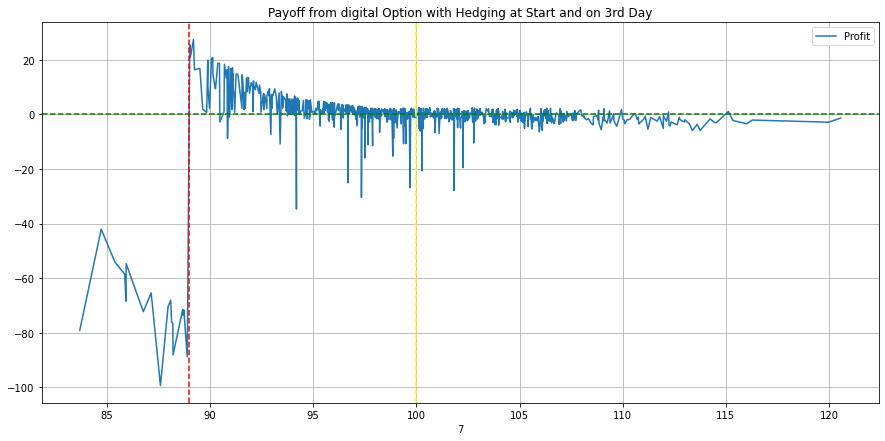

In [1587]:
final.plot(figsize=(15,7),title='Payoff from digital Option with Hedging at Start and on 3rd Day',grid=True)
plt.axvline(x=89,color='Red',ls ='--')
plt.axhline(y=0,color='green',ls ='--')
plt.axvline(x=100,color='yellow',ls ='--')


## Distribution


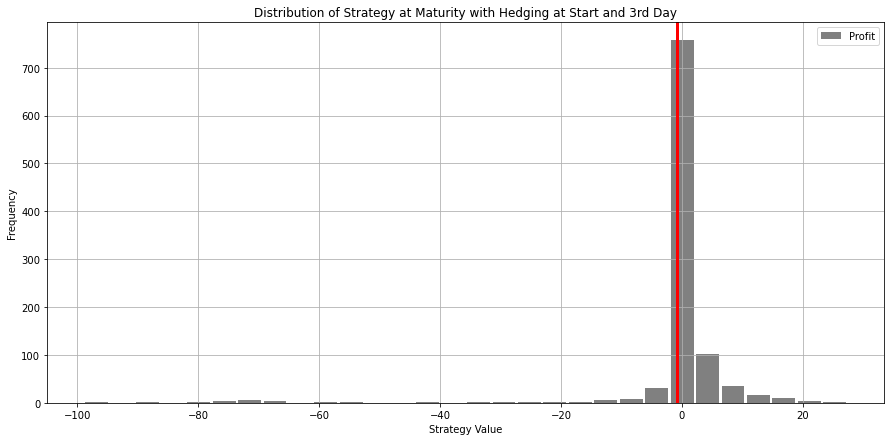

In [1575]:

final.plot.hist(grid=True, bins=30, rwidth=0.9, color='Grey',figsize=(15,7),title='Distribution of Strategy at Maturity with Hedging at Start and 3rd Day')
plt.xlabel("Strategy Value")
plt.axvline(x=df_h.mean().values[0],color='Red', lw=3)

## Key Stats

In [1576]:
final.max(),final.min(),final.std(),-np.percentile(final,0.01)  # Max, # Min, #Standard deviation, # Var

(Profit    27.392104
 dtype: float64,
 Profit   -98.854361
 dtype: float64,
 Profit    10.989482
 dtype: float64,
 97.85389303732838)